<h1>Exploiting Genetic Algorithms for Optimisation </h1>
<br>

<h2> The problem</h2>
We need to make cylindrical containers with fixed volume 30 cubic cm so that, given the diameter you can figure out its height, minimizing the building material. 
This mathematically simple minimization problem could be solved with a genetic algorithm driven by the diameter (or radius) that must always be positive. The rest of the problem definition is up to you. 

In [26]:
#!pip install -r requirements.txt

In [27]:
# Install dependencies
import math
import numpy as np
import time
from tqdm.notebook import tqdm
import pickle
import random

In [28]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

## Defining the Problem

We need to optimise the building material of Cilinders of Volume = 30 cm<sup>3</sup>

$$
\begin{array}{rcl}
    Volume & = & \pi r^2 h\\
    h & = & \frac{30}{\pi r^2}\\
    r & = & x
\end{array}
\newline
$$

In order to minimise the used material, we need to minimise the surface area. 
Thus we get the following equation, for $r > 0$:
$$
\newline
\begin{array}{rcl}
    Area & = & 2\pi r^2 + 2\pi h\\
    & = & 2 \pi r^2 + \frac{60}{r}\\
\end{array}
$$

Then, our fitness equation is:
$$
\begin{array}{rcl}
fitness & = & \dfrac{1}{Area}\\
\\
fitness & = & \dfrac{1}{2 \pi r^2 + \frac{60}{r}}

\end{array}
$$



In [29]:

#1. Initial Hyperparameters
np.random.seed(2023)

#2. Define height given diameter
def height (d):
    ''' 
    Calculates ideal height given a diameter
    Based on the cylinder volume equation: pi * (r**2) * h
    Volume set to 30 as per instructions

    Inputs:
        d   :   Diameter -> type =  (int, float) 

    Outputs: 
        h   :   Height -> type = (float) 
    '''
    r = d/2
    pi = math.pi
    #volume = pi * (r**2) * h
    h = 30/(pi*(r**2))
    return h

#3. Define Fitness
def fitness (r):
    ''' 
    Calculates fitness of the proposed radius
    Based on the fitness equation: 1/(2 * (pi) * (r**2) + (60/r))
    Derived from the optimisation problem

    Inputs:
        r       :   Radius -> type = (int, float)

    Outputs
        fitness :   Fitness -> type = (float)
    '''
    #r=d/2
    area = (2 * (math.pi) * (r**2) + (60/r))
    fitness = 1/area
    return fitness


#4. Binary encoding
#4.1 Binary-encoded first generation
def first_gen(pop_size,n):
    ''' 
    Creates a binary-encoded population of radiuses

    Inputs:
        pop_size    :   Population size (number of individuals in generation) -> type = (int)
        n           :   Number of bits for binary enconding -> type = (int)

    Outputs:
        gen_zero    :   List of n-bits binaty-encoded radiuses of length equal to pop_size 
                        -> type = (list), len(gen_zero) = pop_size
    '''
    gen_zero=[]
    for i in range(pop_size):
        x = []
        while 1 not in x:
            x = [np.random.choice([0, 1]) for _ in range(n)]   
        el = ''.join(map(str, x))
        gen_zero.append(el)

    return gen_zero

#4.2 Function to decode binary radius
def decode_r(r, max_radius, n):
    ''' 
    Converts a binary encoded radius into a number

    Inputs:
        r           :   Binary-encoded radius -> type = (str)
        max_radius  :   upper-bound for the radius -> type = (int)
        n           :   number of bits for encoding -> type = (int)
    
    Outputs:
        dec_r       :   decoded radius -> type = (float)
    '''
    rad=list(map(int, str(r)))
    dec_r=(max_radius/(2**n-1))*sum(rad[i]*2**i for i in range(len(rad)))
    return dec_r
    
#5. Define selection methods
#5.1.1 Calculate fitness for generation and sort individuals by fitness
def ranked_fitness (current_generation, max_radius, n):
    ''' 
    Calculates fitness for all individuals in a generation and returns it in a sorted list

    Inputs:
        current_generation  :   list-like of length n -> type = (list)
        max_radius          :   upper-bound for the radius -> type = (int)
        n                   :   number of bits for encoding -> type = (int)

    Outputs:
        ranked_solutions    :   list of lists [Matrix]-> type = (list), dimensions = (len(current_generation) x 3)
                                each element is of the shape : (fitness, decoded_radius, binary-encoded_radius)
    '''
    ranked_solutions = []
    for el in current_generation:
        ranked_solutions.append([fitness(decode_r(el, max_radius, n)),decode_r(el, max_radius, n), el])
        #added a second element to keep track of solutions and not only fitness
    ranked_solutions.sort(reverse = True)
    return ranked_solutions

#5.1.2 Ranked probabilities for Ranked Selection
def ranked_probabilities(pop_size):
    ''' 
    Create a list of probabilities for each rank in the corresponding index. 

    Inputs:
        pop_size        :   Size of generation -> type : (int)

    Outputs:
        probabilities   :   List of probabilitues for each rank -> type : (list)
    '''
    #based on https://stackoverflow.com/questions/20290831/how-to-perform-rank-based-selection-in-a-genetic-algorithm
    probabilities = []
    amax = 1.2
    amin = 2 - amax
    m = pop_size
    for i in range(pop_size):
        p = (amax - (amax-amin)*(i/(m-1)))*(1/m)
        probabilities.append(p)
    sum_probs = sum(probabilities)
    probabilities[0] = probabilities[0] + (1 - sum_probs)
    return probabilities

#5.1.3 Fitness-based probabilities
def wheel_probabilities(generation):
    ''' 
    Calculates individual probability based on fitness for wheel selection

    Inputs:
        generation                      :   sorted generation fitness -> type : (list), dimensions : len(generation)

    Outputs:
        generation_wheel_probabilities  :   probabilities list -> type : (list), dimensions : len(generation)
    '''

    # computes the total the generation fitness
    generation_fitness = sum([el for el in generation])
    # computes the probability for each radius
    generation_wheel_probabilities = [el/generation_fitness for el in generation]
    return generation_wheel_probabilities

#5.2 Random choice
def random_choice (generation, probabilities, gen_fitness, gen_wheel_probs):
    ''' 
    Chooses a parent randomly from the 30-percentile or better candidates.

    Inputs:
        generation      :   sorted list (by fitness) of binary-encoded radiuses -> type = (list)
        probabilities   :   sorted list of probabilities by rank (used in other selection methods) -> type = (list)
        gen_fitness     :   sorted list of fitness -> type = (list)
        gen_wheel_probs :   probabilities list by fitness (sorted) for wheel selection -> type : (list)
    
    Outputs:
        choice          :   Binary encoded radius (1 parent for reproduction method) -> type = (str)
    '''
    choice = generation[np.random.randint(0, (len(generation)-1)*0.8)]
    return choice

#5.3 Ranked Choice
def ranked_choice (generation, probabilities, gen_fitness, gen_wheel_probs):
    ''' 
    Chooses a parent based on probabilities assigned to rank.

    Inputs:
        generation      :   sorted list (by fitness) of binary-encoded radiuses -> type = (list)
        probabilities   :   sorted list of probabilities by rank (used in other selection methods) -> type = (list)
        gen_fitness     :   sorted list of fitness -> type = (list)
        gen_wheel_probs :   probabilities list by fitness (sorted) for wheel selection -> type : (list)
    
    Outputs:
        choice          :   Binary encoded radius (1 parent for reproduction method) -> type = (str)
    '''
    gen_fit = generation[:50]
    adjusted_probabilities = probabilities[:50]
    sum_probs = sum(adjusted_probabilities)
    adjusted_probabilities[0] = adjusted_probabilities[0] + (1-sum_probs)
    #sorting
    choice= gen_fit[np.random.choice(np.arange(len(gen_fit)), p= adjusted_probabilities)]
    return choice

#5.4 Wheel Choice
def wheel_selection (generation, probabilities, gen_fitness, gen_wheel_probs):
    ''' 
    Chooses a parent based on probabilities assigned to fitness.

    Inputs:
        generation      :   sorted list (by fitness) of binary-encoded radiuses -> type = (list)
        probabilities   :   sorted list of probabilities by rank (used in other selection methods) -> type = (list)
        gen_fitness     :   sorted list of fitness -> type = (list)
        gen_wheel_probs :   probabilities list by fitness (sorted) for wheel selection -> type : (list)
    
    Outputs:
        choice          :   Binary encoded radius (1 parent for reproduction method) -> type = (str)
    '''      
    # selects one parent based on the computed probabilities
    choice= generation[np.random.choice(np.arange(len(generation)), p=gen_wheel_probs)]
    return choice


#6. Define Reproduction methods
#6.1 Crossover Reproduction    
def crossover(parentA, parentB):
    ''' 
    Reproduction method to mix the parents' chromosomes with cut-off single random point

    Inputs:
        parentA :   Binary-encoded radius -> type : (str)
        parentB :   Binary-encoded radius -> type : (str)

    Outputs:
        child   :   Binary-encoded radius -> type : (str)
    '''
    cross_point = np.random.randint(len(parentA))
    child = parentA[:cross_point]+parentB[cross_point:]
    return child

#6.2 Mutations
def mutation(individual, probability):
    ''' 
    Mutation method to invert the child's chromosomes with ##cut-off single random point###??

    Inputs:
        individual  :   Binary-encoded radius -> type = (str)
        probability :   rate of mutation for an individual -> type = (float)

    Outputs:
        individual  :   (Flipped) Binary-encoded radius -> type : (str)
    '''
    flipped = lambda x: '1' if x == '0' else '0'
    chars = (flipped(sym) if random.random() < probability else sym for sym in individual)
    return ''.join(chars)
    

#6.3 Reproduction Behaviour
def reproduction (current_gen, sel_function, ranked_probabilities, gen_fitness, mutation_probability, gen_wheel_probs):
    ''' 
    Function to streamline reproduction with several different hiper-parameters

    Inputs:
        current_gen             :   List of binary-encoded radiuses -> type = (str)
        sel_fuction             :   Python Function fictating the selection of parents -> type = (Function)
        probabilities           :   sorted list of probabilities by rank (used in other selection methods) -> type = (list)
        gen_fitness             :   sorted list of fitness -> type = (list)
        mutation_probability    :   rate of mutation for an individual -> type = (float)
        gen_wheel_probs :   probabilities list by fitness (sorted) for wheel selection -> type : (list)

    Outputs:
        new_generation          :   List of (unsorted) binary-encoded children radiuses -> type = (list)
                                    length = len(current_gen)
    '''
    new_generation = []
    for i in range(len(current_gen)):
        parentA = sel_function(current_gen, ranked_probabilities, gen_fitness, gen_wheel_probs)
        parentB = sel_function(current_gen, ranked_probabilities, gen_fitness, gen_wheel_probs)
        child = crossover(parentA, parentB)
        child = mutation(child, mutation_probability)
        if '1' in child:
            new_generation.append(child)
        else:
            new_generation.append(parentA)
    return new_generation

    

In [30]:
#7 New generation iterations
def digi_evolve(pop_size, max_generations, max_radius, n, sel_function_tuple, ranked_probabilities=[], all_gens=[], mutation_probability=0):
    ''' 
    Genetic Algorithm implementation towards the goal to optimise for. 

    Inputs:
        pop_size                :   Population size (number of individuals in generation) -> type = (int)
        max_generations         :   Number of iterations (generations) to run -> type = (int)
        max_radius              :   upper-bound for the radius -> type = (int)
        n                       :   number of bits for encoding -> type = (int)
        sel_function_tuple      :   tuple-like data structure with function to be called and its name -> type = (tuple -> (Function, str))
        ranked_probabilities    :   sorted list of probabilities by rank (used in other selection methods) -> type = (list)
        all_gens                :   Dictionary to populate with individual's data for future analysis -> type = (dict)
        mutation_probability    :   rate of mutation for an individual -> type = (float)
    
    Outputs:
        fittest                 :   list of best fitting individual's by selection method -> type = (list)
        all_gens                :   Populated Dictionary from all data generated with evolutioniary algorithm -> type = (dict)

    '''
    #create temporary vars
    sel_function = sel_function_tuple[0]
    sel_function_name = sel_function_tuple[1]
    fittest = []
    curr_generation = first_gen(pop_size, n) #initialising first gen

    #GA begins
    #print('Evolutionary period begins')
    for i in range(max_generations):
        ranked_fit = ranked_fitness(curr_generation, max_radius, n)
        fittest.append([ranked_fit[0], i])
        for element in ranked_fit:
            #print('###################### new var', element)
            all_gens['radius'].append(element[1])
            all_gens['fitness'].append(element[0])
            all_gens['generation'].append(i)
            all_gens['selection_type'].append(sel_function_name)
            all_gens['pop_size'].append(pop_size)
            all_gens['mutation'].append(mutation_probability)
        #reproduction
        curr_generation = (np.array(ranked_fit).transpose())
        gen_fitness = np.array(curr_generation[0], dtype= float)
        gen_wheel_probs = wheel_probabilities(gen_fitness)
        curr_generation = reproduction(curr_generation[2], sel_function, \
                                       ranked_probabilities,gen_fitness, mutation_probability,gen_wheel_probs)
        
    #print('Evolutionary period ended')
    return fittest, all_gens


## Solution

Solving by hand, we arrive at the following results:

$$
\begin{array}{rcl}
fitness & = & \dfrac{1}{2 \pi r^2 + \frac{60}{r}}\\
\dfrac{d(fitness)}{dr} & = & 4 \pi r - \frac{60}{r^2} > 0\\
4 \pi r & > & \dfrac{60}{r^2}\\\\
4 \pi & > & \dfrac{60}{r^3}\\\\
\dfrac{4 \pi}{60} & > & \dfrac{1}{r^3}\\
\end{array}
$$

where we get:

$$
\begin{array}{rcl}
 r^3 & > & \dfrac{60}{4 \pi} = \dfrac{15}{\pi}
\end{array}
$$

finally:

$$
\begin{array}{rcl}
r_{att} & = & \sqrt[3]{\dfrac{15}{\pi}} = 1.6841
\end{array}
$$


## Choosing the Number of Bits for Binary Representation

### Calculating Minimum Step:


$$
Interval=[0,r_{max}]
$$
$$
\begin{array}{rcl}
Step & = & \dfrac{r_{max}}{2^n - 1}\\

\end{array}
$$


In [31]:
#Calculating Minimum Step for each number of bits
bits=range(6,15,1)
max_radius=30

print(f"Considering Interval=[0, {max_radius}]:\n")
i=0
for k in bits:
    x=max_radius/(2**k-1)
    print(f"Step with {k} bits: {x}")

Considering Interval=[0, 30]:

Step with 6 bits: 0.47619047619047616
Step with 7 bits: 0.23622047244094488
Step with 8 bits: 0.11764705882352941
Step with 9 bits: 0.05870841487279843
Step with 10 bits: 0.02932551319648094
Step with 11 bits: 0.014655593551538837
Step with 12 bits: 0.007326007326007326
Step with 13 bits: 0.0036625564644121597
Step with 14 bits: 0.0018311664530305805


We chose an 8-bit representation since it provided a minimum increment of 0.1176, which we found suitable for our purpose.


### Calculating Relative Error:
$$
\begin{array}{rcl}
\epsilon & = & \dfrac{r_{estimated} - solution}{solution}\\

\end{array}
$$
Using the known exact result, we were able to examine the Relative Error of the predictions for different bit counts.
We observe that around 8 bits, it is approximately 2%. We consider this percentage acceptable for our analysis.

In [32]:
#Initialing all hyperparameters
pop_size = 100
pop_range_steps = 10
max_generations = 350
#gen_range_steps = 50

#mutation
mutation_list = [0,1, 10, 50, 100]
mutation_rate = 0.001


n=16 #step:0.1176 if we work in range [0,30]
max_radius=30
selection_methods = [[random_choice, 'Random Selection'],\
                    [ranked_choice, 'Ranked Selection'],\
                    [wheel_selection, 'Wheel Selection']]

best_overall = []
all_generations = []
all_gens_best = []

#initialising dict for all vals
all_gens_dict = {
        'radius'        :   [],
        'generation'    :   [],
        'fitness'       :   [], 
        'selection_type':   [], 
        'pop_size'      :   [],
        'mutation'      :   []    
    }

start_total = time.time()
start_local = time.time()

for mutation_el in tqdm(mutation_list, desc='Mutation iterations'): 
    #for loop for different mutation rates
    mutation_probability = mutation_el * mutation_rate
    for selectionMethod in tqdm(selection_methods, desc='Selection Methods'): 
        #for loop for different selection methods
        #print(f'Selection method: {selectionMethod[1]}')
        for pop_length in range(pop_range_steps,pop_size+1, 10):
            #for loop for different population sizes
            ranked_probability = ranked_probabilities(pop_length)
            best_of_each_gen, all_gens = digi_evolve(pop_length, max_generations, max_radius, n, \
                                                     selectionMethod, ranked_probability, all_gens_dict, mutation_probability)

        #print('The best radius is:', max(best_of_each_gen)[0][1], 'in generation: ',max(best_of_each_gen)[1])

        best_overall.append([max(best_of_each_gen), selectionMethod[1]])
        all_gens_best.append([best_of_each_gen, selectionMethod[1], mutation_probability])

        end_local = time.time()
        #print('Time in seconds to complete iteration of', selectionMethod[1] ,end_local - start_local, '\n')
        start_local = time.time()


end_total = time.time()
print('Time in seconds to complete entire cycle:',end_total - start_total, '\n')

#print('The best radius is:', max(best_overall))




Mutation iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Selection Methods:   0%|          | 0/3 [00:00<?, ?it/s]

Selection Methods:   0%|          | 0/3 [00:00<?, ?it/s]

Selection Methods:   0%|          | 0/3 [00:00<?, ?it/s]

Selection Methods:   0%|          | 0/3 [00:00<?, ?it/s]

Selection Methods:   0%|          | 0/3 [00:00<?, ?it/s]

Time in seconds to complete entire cycle: 153.35405802726746 



[[[0.01841751645958127, 1.9047619047619047, '001000'], 49], [[0.018703743102528807, 1.6535433070866141, '1110000'], 49], [[0.01870081198259601, 1.6470588235294117, '01110000'], 49], [[0.018707613264300007, 1.7025440313111546, '101110000'], 49], [[0.018708883203279552, 1.6715542521994136, '1001110000'], 35], [[0.01870987733659405, 1.6853932584269662, '11001110000'], 46], [[0.018709884376721372, 1.684981684981685, '011001110000'], 16], [[0.01870988705875999, 1.6847759736295935, '0011001110000'], 35], [[0.018709888190392165, 1.684673136788134, '00011001110000'], 6]]


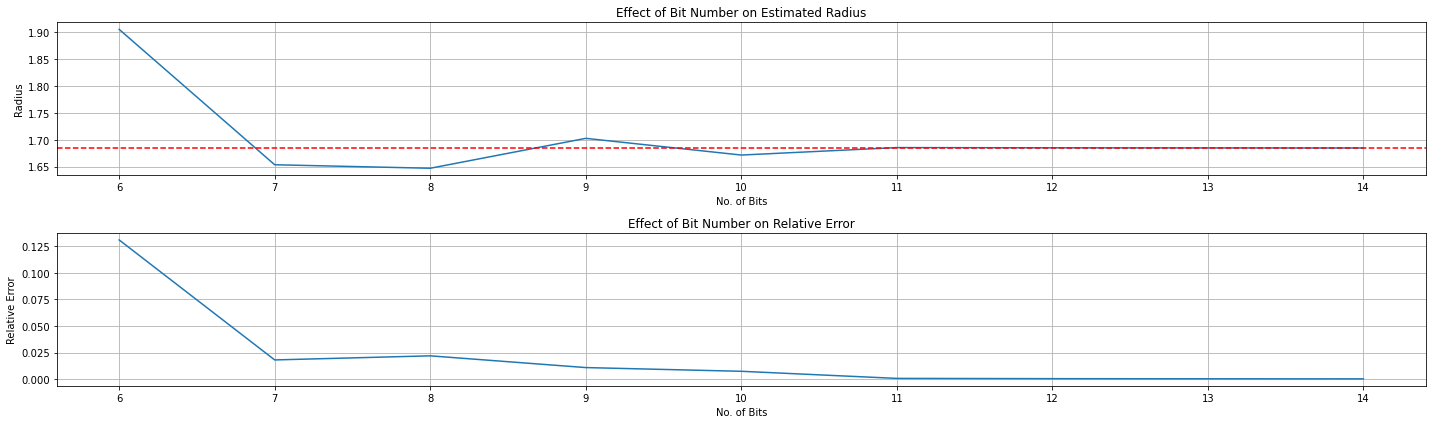

In [33]:
#Relative Error visualization
import matplotlib.pyplot as plt

pop_size=60
generations=50
solution=1.6841

results=[]
result_radius=[]
rel_error=[]

i=0
for k in bits:
    best_of_each_gen = digi_evolve(pop_size, generations, max_radius, k, selectionMethod, ranked_probability, all_gens_dict, mutation_probability )
    results.append(max(best_of_each_gen[0]))
    result_radius.append(results[i][0][1])
    rel_error.append((abs(results[i][0][1]-solution))/solution)
    i+=1

print(results)
#Plotting results
plt.rcParams["figure.figsize"] = (20, 6)

plt.subplot(2,1,1)

plt.title("Effect of Bit Number on Estimated Radius")
plt.xlabel('No. of Bits',fontsize=10)
plt.ylabel('Radius',fontsize=10)
plt.plot(bits,result_radius)   
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.grid()

plt.subplot(2,1,2)

plt.title("Effect of Bit Number on Relative Error")
plt.xlabel('No. of Bits',fontsize=10)
plt.ylabel('Relative Error',fontsize=10)
plt.plot(bits,rel_error)
plt.grid()

plt.tight_layout()
plt.show()

plt.close()

In [34]:
print((all_gens_best[0]))

[[[[0.0181496622202083, 1.4058136873426412, '1111111111010000'], 0], [[0.0181496622202083, 1.4058136873426412, '1111111111010000'], 1], [[0.01814004852678338, 1.4035248340581368, '0101111111010000'], 2], [[0.018679881301236684, 1.6173037308308538, '1011001110110000'], 3], [[0.018679881301236684, 1.6173037308308538, '1011001110110000'], 4], [[0.018693923415855462, 1.6351567864499885, '0010111110110000'], 5], [[0.018691080199176816, 1.6310368505378805, '1101011110110000'], 6], [[0.018691080199176816, 1.6310368505378805, '1101011110110000'], 7], [[0.018691407825738346, 1.6314946211947814, '0011011110110000'], 8], [[0.018706616948732345, 1.6617074845502404, '0111010001110000'], 9], [[0.018706616948732345, 1.6617074845502404, '0111010001110000'], 10], [[0.018706751290030323, 1.6621652552071413, '1111010001110000'], 11], [[0.0186846800223425, 1.6227969787136645, '1001101110110000'], 12], [[0.018685060656248583, 1.6232547493705654, '0101101110110000'], 13], [[0.018693041584865587, 1.734950789

In [35]:
#Save object for Data Analysis
fileObj = open('data_algos.pkl', 'wb')
pickle.dump(all_gens,fileObj)
fileObj.close()
print('Data saved successfully')

Data saved successfully



## Choosing the Number of Bits for Binary Representation

### Calculating Minimum Step:


$$
Interval=[0,r_{max}]
$$
$$
\begin{array}{rcl}
Step & = & \dfrac{r_{max}}{2^n - 1}\\

\end{array}
$$


In [36]:
max_element = max(best_overall, key=lambda x: x[0][0][0])

for element in best_overall:
    if element[0][0][0]!=max_element[0][0][0]: best_overall.remove(element)

min_element = min(best_overall, key=lambda x: x[0][1])

#Showing the best solution found
print(f"The best radius is {min_element[0][0][1]} cm\nFirstly found with {min_element[1]} in generation number {min_element[0][1]}")

The best radius is 1.684138246738384 cm
Firstly found with Wheel Selection in generation number 2


In [37]:
#Save object for Data Analysis
fileObj = open('data_algos.pkl', 'wb')
pickle.dump(all_gens,fileObj)
fileObj.close()
try:
    with open('data_algos.pkl', 'rb') as fileObj:
        loaded_data = pickle.load(fileObj)
        
    print('Data loaded successfully')
    fileObj.close()

except Exception as e:
    print(f'Error loading data: {e}')

Data loaded successfully


## Optimal choices 

After the analysis carried out in the Data Analysis Notebook, we came to the following values being the optimal choices for any family within the defined optimisaition problem. 

The optimal hiperparameters are described below, as well as an example of the Genetic Algorithm performing the specified task. 

In [48]:
#Optimal values
pop_size_op = 60
gen_size_op = 30
n_op = 11
sel_method_op = (ranked_choice, 'Ranked Selection')
#sel_method_op = (wheel_selection, 'Wheel Selection')
max_rad_op = 30
mutation_rate_op = 0.001

all_gens_dict_op = {
        'radius'        :   [],
        'generation'    :   [],
        'fitness'       :   [], 
        'selection_type':   [], 
        'pop_size'      :   [],
        'mutation'      :   []    
    }

start_total = time.time()

ranked_probability_op = ranked_probabilities(pop_size_op)
best_of_each_gen, all_gens = digi_evolve(pop_size_op, gen_size_op, max_rad_op, n_op, \
sel_method_op, ranked_probability_op, all_gens_dict_op, mutation_rate_op)

end_total = time.time()
print('Time in seconds to complete entire cycle:',end_total - start_total, '\n')


Time in seconds to complete entire cycle: 0.11825203895568848 



In [49]:
print(max(best_of_each_gen))

[[0.01870987733659405, 1.6853932584269662, '11001110000'], 29]
